In [8]:
import json
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la
import seaborn as sns

# Initial Exploration

## 40k Dataset
The initial dataset with ~40k lines of kafka log

### User-Movie
User-movie data obtained from kafka stream

In [2]:
df = pd.read_csv("../data/user_movie_40k.csv", header=None)
df = df.rename(columns={0: 'user_id', 1: 'movie_title', 2: 'year', 3: 'movie_id'})
df.head()

,user_id,movie_title,year,movie_id
0,118971,witness,1985.0,witness+1985
1,118971,a bronx tale,1993.0,a+bronx+tale+1993
2,118971,pulp fiction,1994.0,pulp+fiction+1994
3,118971,risky business,1983.0,risky+business+1983
4,118971,gladiator,2000.0,gladiator+2000


In [3]:
df.shape

(42033, 4)

In [4]:
df.nunique(axis=0)

user_id        3286
movie_title    4831
year             98
movie_id       4949
dtype: int64

In [5]:
df.describe()

,user_id,year
count,42033.000000,42032.000000
mean,85177.365475,1991.792563
std,49686.965494,12.824947
min,35.000000,1916.000000
25%,41168.000000,1990.000000
50%,86738.000000,1995.000000
75%,128140.000000,1999.000000
max,169638.000000,2015.000000


### Movies
Movie data from API

In [7]:
movies = pd.read_csv("../data/movies_40k.csv")
movies.head()

,adult,budget,genres,movieid,imdb_id,original_language,original_title,overview,popularity,release_date,revenue,runtime,status,title,tmdb_id,vote_average,vote_count
0,False,12000000,"Crime,Drama,Romance,Thriller",witness+1985,tt0090329,en,Witness,A sheltered Amish child is the sole witness of...,10.312017,1985-02-08,68706993,113,Released,Witness,9281,7.0,390
1,False,22000000,"Drama,Crime",a+bronx+tale+1993,tt0106489,en,A Bronx Tale,"Set in the Bronx during the tumultuous 1960s, ...",6.115628,1993-09-14,17287898,121,Released,A Bronx Tale,1607,7.4,447
2,False,8000000,"Thriller,Crime",pulp+fiction+1994,tt0110912,en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",140.950236,1994-09-10,213928762,154,Released,Pulp Fiction,680,8.3,8670
3,False,6200000,"Comedy,Romance",risky+business+1983,tt0086200,en,Risky Business,"Meet Joel Goodson, an industrious, college-bou...",6.505209,1983-08-05,63541777,98,Released,Risky Business,9346,6.4,340
4,False,103000000,"Action,Drama,Adventure",gladiator+2000,tt0172495,en,Gladiator,"In the year 180, the death of emperor Marcus A...",23.186667,2000-05-01,457640427,155,Released,Gladiator,98,7.9,5566


In [8]:
movies.shape

(4945, 17)

In [9]:
movies.columns

Index(['adult', 'budget', 'genres', 'movieid', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'release_date', 'revenue',
       'runtime', 'status', 'title', 'tmdb_id', 'vote_average', 'vote_count'],
      dtype='object')

In [10]:
genres = (movies.genres.str.split('\s*,\s*', expand=True)
   .stack()
   .str.get_dummies()
   .sum(level=0))
genres.columns = ["genre_"+x.lower() for x in genres.columns]

In [11]:
movies = pd.merge(movies, genres, left_index=True, right_index=True)

In [12]:
movies.head()

,adult,budget,genres,movieid,imdb_id,original_language,original_title,overview,popularity,release_date,...,genre_history,genre_horror,genre_music,genre_mystery,genre_romance,genre_science fiction,genre_tv movie,genre_thriller,genre_war,genre_western
0,False,12000000,"Crime,Drama,Romance,Thriller",witness+1985,tt0090329,en,Witness,A sheltered Amish child is the sole witness of...,10.312017,1985-02-08,...,0,0,0,0,1,0,0,1,0,0
1,False,22000000,"Drama,Crime",a+bronx+tale+1993,tt0106489,en,A Bronx Tale,"Set in the Bronx during the tumultuous 1960s, ...",6.115628,1993-09-14,...,0,0,0,0,0,0,0,0,0,0
2,False,8000000,"Thriller,Crime",pulp+fiction+1994,tt0110912,en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",140.950236,1994-09-10,...,0,0,0,0,0,0,0,1,0,0
3,False,6200000,"Comedy,Romance",risky+business+1983,tt0086200,en,Risky Business,"Meet Joel Goodson, an industrious, college-bou...",6.505209,1983-08-05,...,0,0,0,0,1,0,0,0,0,0
4,False,103000000,"Action,Drama,Adventure",gladiator+2000,tt0172495,en,Gladiator,"In the year 180, the death of emperor Marcus A...",23.186667,2000-05-01,...,0,0,0,0,0,0,0,0,0,0


In [13]:
movies.to_csv("../data/movies_40k.csv", index_col = False)

### User
User data obtained from API

In [14]:
users =  pd.read_csv("../data/users_40k.csv")
users.head()

,user_id,gender,occupation,age
0,118971,M,sales/marketing,33
1,141755,F,executive/managerial,34
2,199,M,academic/educator,49
3,111053,M,sales/marketing,29
4,67650,M,executive/managerial,27


In [15]:
users.shape

(3286, 4)

### Data Exploration

#### Most watched movie

In [16]:
movie_count = df['movie_id'].value_counts()
movie_count.nlargest(20)

pulp+fiction+1994                 248
forrest+gump+1994                 244
the+shawshank+redemption+1994     239
jurassic+park+1993                227
the+silence+of+the+lambs+1991     219
braveheart+1995                   193
dances+with+wolves+1990           186
star+wars+1977                    180
batman+1989                       177
terminator+2+judgment+day+1991    173
apollo+13+1995                    173
the+fugitive+1993                 169
independence+day+1996             168
toy+story+1995                    167
schindlers+list+1993              165
true+lies+1994                    161
aladdin+1992                      160
the+matrix+1999                   156
twelve+monkeys+1995               156
american+beauty+1999              151
Name: movie_id, dtype: int64

#### Correlation

In [17]:
movies_with_count = pd.merge(movies, movie_count, left_on="movieid", right_index=True)
movies_with_count = movies_with_count.rename(columns={"movie_id": "count"})

In [18]:
corr = movies_with_count.corr()
corr = corr.drop(columns=['adult', 'tmdb_id'])
corr = corr.drop(index=['adult', 'tmdb_id'])
corr

,budget,popularity,revenue,runtime,vote_average,vote_count,genre_action,genre_adventure,genre_animation,genre_comedy,...,genre_horror,genre_music,genre_mystery,genre_romance,genre_science fiction,genre_tv movie,genre_thriller,genre_war,genre_western,count
budget,1.000000,0.378789,0.741607,0.236707,-0.050877,0.608413,0.306187,0.335862,0.140915,-0.088497,...,-0.082554,-0.059262,0.015059,-0.098812,0.179318,-0.021025,0.097948,0.008334,-0.000557,0.143860
popularity,0.378789,1.000000,0.500216,0.173594,0.194123,0.616837,0.152336,0.159414,0.090782,-0.091814,...,0.000841,-0.040448,0.031882,-0.085248,0.103066,-0.019875,0.095896,0.014261,0.002833,0.302215
revenue,0.741607,0.500216,1.000000,0.219988,0.098156,0.786473,0.209098,0.304246,0.149908,-0.068046,...,-0.066996,-0.041622,-0.003647,-0.068466,0.123790,-0.017493,0.036266,-0.000762,-0.025057,0.332693
runtime,0.236707,0.173594,0.219988,1.000000,0.258752,0.227908,0.078512,0.061311,-0.228980,-0.254306,...,-0.134816,0.031540,0.053953,0.048901,-0.029480,-0.008690,0.038293,0.167565,0.060877,0.167202
vote_average,-0.050877,0.194123,0.098156,0.258752,1.000000,0.250034,-0.120377,-0.048986,0.076373,-0.192916,...,-0.122604,0.047345,0.039100,-0.025675,-0.092654,-0.038726,-0.052083,0.097289,0.036474,0.205433
vote_count,0.608413,0.616837,0.786473,0.227908,0.250034,1.000000,0.197234,0.233655,0.106247,-0.116773,...,-0.045906,-0.057109,0.020541,-0.100519,0.167905,-0.017334,0.066032,0.009813,-0.009648,0.413223
genre_action,0.306187,0.152336,0.209098,0.078512,-0.120377,0.197234,1.000000,0.386948,-0.043891,-0.156124,...,-0.064557,-0.075772,-0.044303,-0.191891,0.225114,-0.006219,0.284787,0.057890,0.050344,0.083186
genre_adventure,0.335862,0.159414,0.304246,0.061311,-0.048986,0.233655,0.386948,1.000000,0.169759,-0.081743,...,-0.104493,-0.050527,-0.066651,-0.133243,0.184659,-0.016469,0.006947,0.015217,0.065482,0.093773
genre_animation,0.140915,0.090782,0.149908,-0.228980,0.076373,0.106247,-0.043891,0.169759,1.000000,0.008239,...,-0.068849,0.032333,-0.059178,-0.085191,0.041020,0.015892,-0.119083,-0.032341,-0.023471,0.016909
genre_comedy,-0.088497,-0.091814,-0.068046,-0.254306,-0.192916,-0.116773,-0.156124,-0.081743,0.008239,1.000000,...,-0.150844,0.017242,-0.173437,0.174179,-0.112137,0.003439,-0.327508,-0.101823,-0.040584,-0.039696


<AxesSubplot:>

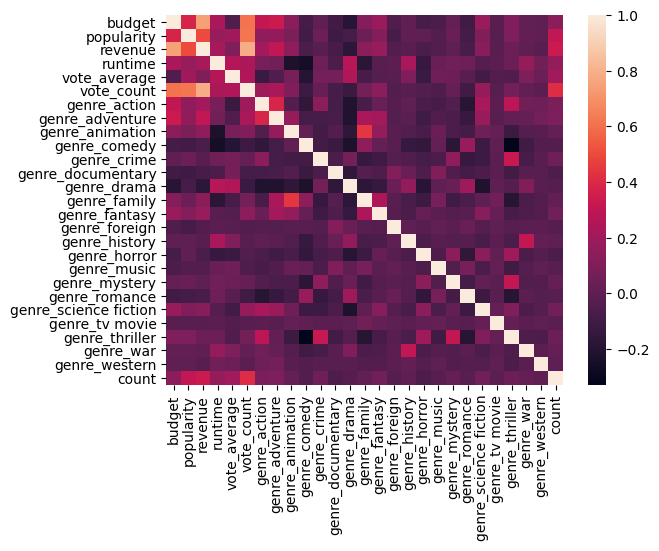

In [19]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

#### Sparsity

In [20]:
n_users = df.user_id.unique().shape[0]
n_items = df.movie_id.unique().shape[0]
sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
print('Number of users: {}'.format(n_users))
print('Number of movies: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))

Number of users: 3286
Number of movies: 4949
Sparsity: 0.258%


# Create Dataset

## 1.5M Dataset
Dataset created from 7M lines of Kafka log taken in September 11, 2022. This dataset containes roughly 1.5M unique user-movie combination

In [9]:
df = pd.read_csv("../data/user_movie_1500k.csv")
df.head()

,user_id,movie_name,year,movie_id,minute
0,54948,forrest gump,1994.0,forrest+gump+1994,0
1,54948,the piano,1993.0,the+piano+1993,0
2,54948,forget paris,1995.0,forget+paris+1995,0
3,54948,the client,1994.0,the+client+1994,0
4,54948,the silence of the lambs,1991.0,the+silence+of+the+lambs+1991,0


In [3]:
df.shape

(1492308, 4)

In [4]:
df.nunique(axis=0)

user_id       94641
movie_name    14580
year            112
movie_id      15224
dtype: int64

In [4]:
movie_count = df['movie_id'].value_counts()
movie_count.nlargest(50)

pulp+fiction+1994                                        9302
the+shawshank+redemption+1994                            9078
forrest+gump+1994                                        8728
the+silence+of+the+lambs+1991                            8644
jurassic+park+1993                                       7523
apollo+13+1995                                           6812
braveheart+1995                                          6787
the+fugitive+1993                                        6626
dances+with+wolves+1990                                  6543
star+wars+1977                                           6474
batman+1989                                              6459
schindlers+list+1993                                     6331
toy+story+1995                                           6301
terminator+2+judgment+day+1991                           6068
true+lies+1994                                           5925
independence+day+1996                                    5779
aladdin+

In [7]:
movie_count.to_csv('../data/movies_top_100.csv')

In [11]:
n_users = df.user_id.unique().shape[0]
n_items = df.movie_id.unique().shape[0]
sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
print('Number of users: {}'.format(n_users))
print('Number of movies: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))

Number of users: 94641
Number of movies: 15224
Sparsity: 0.104%


In [8]:
movies = pd.read_csv("../data/movies_1500k_without_genre.csv")

In [9]:
genres = (movies.genres.str.split('\s*,\s*', expand=True)
   .stack()
   .str.get_dummies()
   .sum(level=0))
genres.columns = ["genre_"+x.lower() for x in genres.columns]

movies = pd.merge(movies, genres, left_index=True, right_index=True)

movies.to_csv("../data/movies_1500k.csv", index= False)  

In [10]:
movies.head()

,adult,budget,genres,movieid,imdb_id,original_language,original_title,overview,popularity,release_date,...,genre_history,genre_horror,genre_music,genre_mystery,genre_romance,genre_science fiction,genre_tv movie,genre_thriller,genre_war,genre_western
0,False,8000000,"Thriller,Crime",pulp+fiction+1994,tt0110912,en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",140.950236,1994-09-10,...,0,0,0,0,0,0,0,1,0,0
1,False,28000000,Adventure,rob+roy+1995,tt0114287,en,Rob Roy,"In the highlands of Scotland in the 1700s, Rob...",10.193549,1995-04-13,...,0,0,0,0,0,0,0,0,0,0
2,False,30000000,"Fantasy,Drama,Comedy,Family",babe+1995,tt0112431,en,Babe,Babe is a little pig who doesn't quite know hi...,14.404764,1995-07-18,...,0,0,0,0,0,0,0,0,0,0
3,False,7000000,"Drama,Romance",the+piano+1993,tt0107822,en,The Piano,"After a long voyage from Scotland, pianist Ada...",7.436758,1993-05-19,...,0,0,0,0,1,0,0,0,0,0
4,False,1300000,"Crime,Drama",taxi+driver+1976,tt0075314,en,Taxi Driver,A mentally unstable Vietnam War veteran works ...,14.092713,1976-02-07,...,0,0,0,0,0,0,0,0,0,0


In [11]:
users = pd.read_csv("../data/users_1500k.csv")

In [12]:
users.head()

,user_id,gender,occupation,age
0,54948,M,executive/managerial,33
1,90134,M,college/grad student,29
2,133452,F,college/grad student,27
3,143240,F,executive/managerial,27
4,100697,M,artist,31


## 100k Dataset
Sample a smaller 100k Dataset

In [13]:
df100k = df.sample(n=180000, random_state=0)

In [14]:
n_users = df100k.user_id.unique().shape[0]
n_items = df100k.movie_id.unique().shape[0]
sparsity = float(df100k.shape[0]) / float(n_users*n_items) * 100
print('Number of users: {}'.format(n_users))
print('Number of movies: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))

Number of users: 72612
Number of movies: 8220
Sparsity: 0.030%


Sparsity is less than 0.1%, so we'll drop users who watched less than 3 movies and movies that has been watched less than 3 users to make it denser.

In [15]:
movie_id_min = 3
user_id_min = 3

n_users = df100k.user_id.unique().shape[0]
n_items = df100k.movie_id.unique().shape[0]
sparsity = float(df100k.shape[0]) / float(n_users*n_items) * 100
print('Starting info')
print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))
print('Number of data:{}'.format(df100k.shape[0]))

done = False
while not done:
    starting_shape = df100k.shape[0]
    movie_id_counts = df100k.groupby('user_id').movie_id.count()
    df100k = df100k[~df100k.user_id.isin(movie_id_counts[movie_id_counts < movie_id_min].index.tolist())]
    user_id_counts = df100k.groupby('movie_id').user_id.count()
    df100k = df100k[~df100k.movie_id.isin(user_id_counts[user_id_counts < user_id_min].index.tolist())]
    ending_shape = df100k.shape[0]
    if starting_shape == ending_shape:
        done = True

assert(df100k.groupby('user_id').movie_id.count().min() >= movie_id_min)
assert(df100k.groupby('movie_id').user_id.count().min() >= user_id_min)

n_users = df100k.user_id.unique().shape[0]
n_items = df100k.movie_id.unique().shape[0]
sparsity = float(df100k.shape[0]) / float(n_users*n_items) * 100
print('\nEnding info')
print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))
print('Number of data: {}'.format(df100k.shape[0]))

Starting info
Number of users: 72612
Number of models: 8220
Sparsity: 0.030%
Number of data:180000

Ending info
Number of users: 28348
Number of models: 3720
Sparsity: 0.104%
Number of data: 109753


Now we end up with around 100k rows of data.

In [16]:
df100k.to_csv("../data/user_movie_100k.csv", index=False) 

In [17]:
df100k = pd.read_csv("../data/user_movie_100k.csv")

In [18]:
df100k.nunique(axis=0)

user_id       28348
movie_name     3646
year             91
movie_id       3720
dtype: int64

In [19]:
movies100k = movies[movies.movieid.isin(df100k.movie_id.unique())]

In [20]:
movies100k.shape

(3712, 37)

In [21]:
movies100k.to_csv("../data/movies_100k.csv", index=False) 

In [22]:
users100k = users[users.user_id.isin(df100k.user_id.unique())]

In [23]:
users100k.shape

(28348, 4)

In [24]:
users100k.to_csv("../data/users_100k.csv", index=False) 

## 500k Dataset

In [25]:
df500k = df.sample(n=530000, random_state=0)

In [26]:
n_users = df500k.user_id.unique().shape[0]
n_items = df500k.movie_id.unique().shape[0]
sparsity = float(df500k.shape[0]) / float(n_users*n_items) * 100
print('Number of users: {}'.format(n_users))
print('Number of movies: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))

Number of users: 87541
Number of movies: 11423
Sparsity: 0.011%


In [27]:
movie_id_min = 3
user_id_min = 3

n_users = df500k.user_id.unique().shape[0]
n_items = df500k.movie_id.unique().shape[0]
sparsity = float(df500k.shape[0]) / float(n_users*n_items) * 100
print('Starting info')
print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))
print('Number of data:{}'.format(df500k.shape[0]))

done = False
while not done:
    starting_shape = df500k.shape[0]
    movie_id_counts = df500k.groupby('user_id').movie_id.count()
    df500k = df500k[~df500k.user_id.isin(movie_id_counts[movie_id_counts < movie_id_min].index.tolist())]
    user_id_counts = df500k.groupby('movie_id').user_id.count()
    df500k = df500k[~df500k.movie_id.isin(user_id_counts[user_id_counts < user_id_min].index.tolist())]
    ending_shape = df500k.shape[0]
    if starting_shape == ending_shape:
        done = True

assert(df500k.groupby('user_id').movie_id.count().min() >= movie_id_min)
assert(df500k.groupby('movie_id').user_id.count().min() >= user_id_min)

n_users = df500k.user_id.unique().shape[0]
n_items = df500k.movie_id.unique().shape[0]
sparsity = float(df500k.shape[0]) / float(n_users*n_items) * 100
print('\nEnding info')
print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))
print('Number of data: {}'.format(df500k.shape[0]))

Starting info
Number of users: 87541
Number of models: 11423
Sparsity: 0.053%
Number of data:530000

Ending info
Number of users: 73093
Number of models: 6736
Sparsity: 0.102%
Number of data: 503794


In [28]:
df500k.to_csv("../data/user_movie_500k.csv", index=False) 

In [10]:
df500k = pd.read_csv("../data/user_movie_500k.csv")

In [30]:
df500k.nunique(axis=0)

user_id       73093
movie_name     6524
year             98
movie_id       6736
dtype: int64

In [31]:
movies500k = movies[movies.movieid.isin(df500k.movie_id.unique())]

In [32]:
movies500k.to_csv("../data/movies_500k.csv", index=False) 

In [33]:
users500k = users[users.user_id.isin(df500k.user_id.unique())]

In [34]:
users500k.shape

(73093, 4)

In [35]:
users500k.to_csv("../data/users_500k.csv", index=False) 

# With Threshold

In [2]:
df = pd.read_csv("../data/user_movie_1500k.csv")
df.head()

,user_id,movie_name,year,movie_id,minute
0,54948,forrest gump,1994.0,forrest+gump+1994,0
1,54948,the piano,1993.0,the+piano+1993,0
2,54948,forget paris,1995.0,forget+paris+1995,0
3,54948,the client,1994.0,the+client+1994,0
4,54948,the silence of the lambs,1991.0,the+silence+of+the+lambs+1991,0


In [3]:
df.nunique()

user_id       94641
movie_name    14580
year            112
movie_id      15224
minute          243
dtype: int64

In [4]:
df.shape

(1492308, 5)

In [9]:
df_th15 = df[df['minute']>=15]
df_th15.shape

(56671, 5)

In [10]:
df_th15.nunique()

user_id       9794
movie_name    7689
year           105
movie_id      7915
minute         228
dtype: int64

In [7]:
df_th30 = df[df['minute']>=30]
df_th30.shape

(53932, 5)

In [8]:
df_th30.nunique()

user_id       7920
movie_name    6912
year           103
movie_id      7103
minute         213
dtype: int64

In [14]:
n_users = df_th30.user_id.unique().shape[0]
n_items = df_th30.movie_id.unique().shape[0]
sparsity = float(df_th30.shape[0]) / float(n_users*n_items) * 100
print('Number of users: {}'.format(n_users))
print('Number of movies: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(sparsity))

Number of users: 7920
Number of movies: 7103
Sparsity: 0.096%


In [12]:
df_th60 = df[df['minute']>=60]
df_th60.shape

(48704, 5)

In [13]:
df_th60.nunique()

user_id       4437
movie_name    5302
year            99
movie_id      5438
minute         183
dtype: int64